# 02 - Entrainement du CycleGAN

Ce notebook entraine un CycleGAN pour apprendre la transformation
bidirectionnelle entre images agricoles normales et en conditions de secheresse.

**Pipeline :**
1. Preparer les donnees (domaine A = normal, domaine B = secheresse simulee)
2. Initialiser le CycleGAN avec sauvegarde Drive
3. Entrainer (~3-5h sur GPU T4 Colab) avec auto-resume
4. Visualiser les resultats
5. Sauvegarder le modele final dans Drive

In [1]:
"""
Configuration Google Drive pour sauvegarde outputs.
Les notebooks restent sur GitHub, seuls les checkpoints/resultats vont dans Drive.
"""

from google.colab import drive
import os
import sys

# Montage Drive
drive.mount('/content/drive', force_remount=True)

# Chemin racine pour les outputs uniquement
DRIVE_OUTPUTS = "/content/drive/MyDrive/SatelliteGAN-Outputs"

# Creation structure outputs
for subdir in [
    'data/eurosat', 'data/processed_drought',
    'cyclegan/checkpoints', 'cyclegan/generated_images', 'cyclegan/losses',
    'diffusion/checkpoints', 'diffusion/samples', 'diffusion/losses',
    'evaluation/metrics', 'evaluation/comparisons', 'evaluation/figures',
]:
    os.makedirs(f"{DRIVE_OUTPUTS}/{subdir}", exist_ok=True)

print(f"Drive monte : {DRIVE_OUTPUTS}")
print(f"Structure outputs creee")

# Clone du repo GitHub (code source)
if not os.path.exists('/content/SatelliteGAN-Climate-Agriculture'):
    !git clone https://github.com/aymenssf/SatelliteGAN-Climate-Agriculture.git /content/SatelliteGAN-Climate-Agriculture
    !pip install -q -r /content/SatelliteGAN-Climate-Agriculture/requirements.txt

%cd /content/SatelliteGAN-Climate-Agriculture
sys.path.insert(0, '/content/SatelliteGAN-Climate-Agriculture')

print("Code source charge depuis GitHub")
print("Outputs seront sauvegardes dans Drive")

Mounted at /content/drive
Drive monte : /content/drive/MyDrive/SatelliteGAN-Outputs
Structure outputs creee
Cloning into '/content/SatelliteGAN-Climate-Agriculture'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 62 (delta 22), reused 41 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 1.19 MiB | 4.99 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/SatelliteGAN-Climate-Agriculture
Code source charge depuis GitHub
Outputs seront sauvegardes dans Drive


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from src.config import DEVICE, CYCLEGAN, IMAGE_SIZE
from src.dataset import get_agricultural_dataset, split_dataset
from src.preprocessing import (
    get_cyclegan_transform, get_eval_transform,
    simulate_drought, denormalize, tensor_to_numpy
)
from src.cyclegan.train import CycleGANTrainer
from src.evaluation.visualization import (
    show_cyclegan_results, show_comparison, plot_training_losses
)

print(f"Device : {DEVICE}")
print(f"Configuration CycleGAN : {CYCLEGAN}")

Device : cuda
Configuration CycleGAN : {'n_residual_blocks': 6, 'batch_size': 4, 'lr': 0.0002, 'betas': (0.5, 0.999), 'lambda_cycle': 10.0, 'lambda_identity': 5.0, 'n_epochs': 100, 'decay_epoch': 50, 'save_every': 10, 'replay_buffer_size': 50}


## 1. Preparation des donnees

On cree deux domaines :
- **Domaine A** : images agricoles normales (EuroSAT)
- **Domaine B** : images agricoles avec secheresse simulee

Le CycleGAN n'a pas besoin de paires appariees, mais on cree
les deux domaines a partir du meme dataset pour comparer.

In [3]:
from torchvision import transforms
from PIL import Image

# Charger le dataset brut (sans normalisation) pour appliquer la simulation
raw_transform = transforms.Resize(IMAGE_SIZE)
raw_dataset = get_agricultural_dataset(transform=raw_transform)

# Split
train_set, val_set, _ = split_dataset(raw_dataset)

print(f"Images d'entrainement : {len(train_set)}")

100%|██████████| 94.3M/94.3M [00:01<00:00, 61.3MB/s]


EuroSAT agricole : 10500 images, 4 classes ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']
Split : train=8400, val=1050, test=1050
Images d'entrainement : 8400


In [4]:
# Creer les tensors pour les deux domaines
cyclegan_transform = get_cyclegan_transform()
eval_transform = get_eval_transform()

def prepare_paired_batch(dataset, transform, n_max=None):
    """
    Prepare les batches pour le CycleGAN.
    Domaine A = images normales normalisees
    Domaine B = images secheresse normalisees
    """
    images_a = []
    images_b = []
    n = min(len(dataset), n_max) if n_max else len(dataset)

    for i in range(n):
        img, _ = dataset[i]

        # Convertir en PIL si c'est un tensor
        if isinstance(img, torch.Tensor):
            img_pil = transforms.ToPILImage()(img)
        else:
            img_pil = img

        # Domaine A : normal
        img_a = transform(img_pil)

        # Domaine B : secheresse simulee
        drought_pil = simulate_drought(img_pil, severity=0.6)
        img_b = transform(drought_pil)

        images_a.append(img_a)
        images_b.append(img_b)

    return torch.stack(images_a), torch.stack(images_b)

print("Preparation des donnees d'entrainement...")
train_a, train_b = prepare_paired_batch(train_set, cyclegan_transform)
print(f"Domaine A : {train_a.shape}")
print(f"Domaine B : {train_b.shape}")

Preparation des donnees d'entrainement...
Domaine A : torch.Size([8400, 3, 64, 64])
Domaine B : torch.Size([8400, 3, 64, 64])


In [9]:
# Creer le DataLoader optimise pour GPU
train_dataset = TensorDataset(train_a, train_b)
train_loader = DataLoader(
    train_dataset,
    batch_size=CYCLEGAN['batch_size'],  # 4
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

print(f"Batch size : {CYCLEGAN['batch_size']}")
print(f"Nombre de batches par epoch : {len(train_loader)}")
print("DataLoader optimise (num_workers=2, pin_memory=True)")

Batch size : 4
Nombre de batches par epoch : 2100
DataLoader optimise (num_workers=2, pin_memory=True)


## 2. Initialisation du CycleGAN

Le `save_dir` pointe vers Google Drive pour que les checkpoints,
images generees et historique des pertes survivent aux deconnexions Colab.

Si un checkpoint existe deja dans Drive, l'entrainement reprend
automatiquement depuis le dernier checkpoint (auto-resume).

In [6]:
# Creer le trainer avec sauvegarde Drive
trainer = CycleGANTrainer(
    save_dir=f"{DRIVE_OUTPUTS}/cyclegan"  # Checkpoints, images, pertes -> Drive
)

# Compter les parametres
n_params_G = sum(p.numel() for p in trainer.G_A2B.parameters())
n_params_D = sum(p.numel() for p in trainer.D_A.parameters())
print(f"Parametres Generateur : {n_params_G:,}")
print(f"Parametres Discriminateur : {n_params_D:,}")
print(f"Total : {2*n_params_G + 2*n_params_D:,}")

Parametres Generateur : 7,833,987
Parametres Discriminateur : 2,763,841
Total : 21,195,656


In [10]:
# ============================================================
# Mixed Precision (AMP) - Accelere l'entrainement de ~30-40%
# Utilise FP16 pour les calculs, FP32 pour les mises a jour
# Sans perte de qualite pour les GANs a cette resolution
# ============================================================
from torch.amp import autocast, GradScaler
from src.config import DEVICE

scaler_G = GradScaler()
scaler_D_A = GradScaler()
scaler_D_B = GradScaler()

_original_train_step = trainer.train_step

def _amp_train_step(self, real_a, real_b):
    real_a = real_a.to(DEVICE)
    real_b = real_b.to(DEVICE)

    # ---- Generateurs avec AMP ----
    self.opt_G.zero_grad()
    with autocast('cuda'):
        fake_b = self.G_A2B(real_a)
        fake_a = self.G_B2A(real_b)
        cycle_a = self.G_B2A(fake_b)
        cycle_b = self.G_A2B(fake_a)
        idt_a = self.G_B2A(real_a)
        idt_b = self.G_A2B(real_b)
        pred_fake_a = self.D_A(fake_a)
        pred_fake_b = self.D_B(fake_b)
        loss_G, components = self.loss_fn.generator_loss(
            pred_fake_a, pred_fake_b,
            cycle_a, real_a, cycle_b, real_b,
            idt_a, idt_b,
        )

    scaler_G.scale(loss_G).backward()
    scaler_G.step(self.opt_G)
    scaler_G.update()

    # ---- Discriminateur A avec AMP ----
    self.opt_D_A.zero_grad()
    fake_a_buffer = self.buffer_A.push_and_pop(fake_a.detach())
    with autocast('cuda'):
        pred_real_a = self.D_A(real_a)
        pred_fake_a = self.D_A(fake_a_buffer)
        loss_D_A = self.loss_fn.discriminator_loss(pred_real_a, pred_fake_a)

    scaler_D_A.scale(loss_D_A).backward()
    scaler_D_A.step(self.opt_D_A)
    scaler_D_A.update()

    # ---- Discriminateur B avec AMP ----
    self.opt_D_B.zero_grad()
    fake_b_buffer = self.buffer_B.push_and_pop(fake_b.detach())
    with autocast('cuda'):
        pred_real_b = self.D_B(real_b)
        pred_fake_b = self.D_B(fake_b_buffer)
        loss_D_B = self.loss_fn.discriminator_loss(pred_real_b, pred_fake_b)

    scaler_D_B.scale(loss_D_B).backward()
    scaler_D_B.step(self.opt_D_B)
    scaler_D_B.update()

    return {
        'loss_G': loss_G.item(),
        'loss_D_A': loss_D_A.item(),
        'loss_D_B': loss_D_B.item(),
        'loss_cycle': components['cycle_a'] + components['cycle_b'],
        'loss_identity': components['identity'],
    }

# Remplacer train_step par la version AMP
import types
trainer.train_step = types.MethodType(_amp_train_step, trainer)

print("Mixed Precision (AMP) active")
print("Gain estime : ~30-40% plus rapide, meme qualite")

Mixed Precision (AMP) active
Gain estime : ~30-40% plus rapide, meme qualite


## 3. Entrainement

L'entrainement alterne entre les generateurs et les discriminateurs.
Le replay buffer stabilise l'entrainement.

**Sauvegarde automatique :**
- Checkpoints tous les 10 epochs dans `Drive/SatelliteGAN-Outputs/cyclegan/checkpoints/`
- Images A->B et B->A dans `Drive/SatelliteGAN-Outputs/cyclegan/generated_images/`
- Historique pertes (JSON) dans `Drive/SatelliteGAN-Outputs/cyclegan/losses/`

**Auto-resume :** si l'entrainement est interrompu, relancer cette cellule.
Le trainer detecte le dernier checkpoint et reprend automatiquement.

In [11]:
# Entrainer le modele
# Reduire n_epochs pour un test rapide (ex: 5-10 epochs)
# Pour l'entrainement complet, utiliser CYCLEGAN['n_epochs'] (100)
N_EPOCHS = CYCLEGAN['n_epochs']  # mettre 5 pour un test rapide

# L'auto-resume detecte les checkpoints existants dans Drive.
# Pour forcer une reprise depuis un checkpoint specifique :
#   history = trainer.train(train_loader, n_epochs=N_EPOCHS,
#                           resume_from=f"{DRIVE_OUTPUTS}/cyclegan/checkpoints/epoch_40.pth")

history = trainer.train(train_loader, n_epochs=N_EPOCHS)

Checkpoint charge : epoch 60
Reprise de l'entrainement a l'epoch 60/100


Epoch 61/100: 100%|██████████| 2100/2100 [03:05<00:00, 11.32it/s, G=2.691, D_A=0.143, D_B=0.175]


[Epoch 61] G: 2.9713 | D_A: 0.1822 | D_B: 0.1813 | Cycle: 1.5337


Epoch 62/100: 100%|██████████| 2100/2100 [03:08<00:00, 11.16it/s, G=2.126, D_A=0.119, D_B=0.098]


[Epoch 62] G: 2.9965 | D_A: 0.1504 | D_B: 0.1515 | Cycle: 1.4947


Epoch 63/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.19it/s, G=2.470, D_A=0.154, D_B=0.102]


[Epoch 63] G: 2.9863 | D_A: 0.1457 | D_B: 0.1346 | Cycle: 1.4435


Epoch 64/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.17it/s, G=2.734, D_A=0.112, D_B=0.180]


[Epoch 64] G: 2.9747 | D_A: 0.1298 | D_B: 0.1264 | Cycle: 1.3809


Epoch 65/100: 100%|██████████| 2100/2100 [03:08<00:00, 11.17it/s, G=2.525, D_A=0.083, D_B=0.176]


[Epoch 65] G: 2.9892 | D_A: 0.1235 | D_B: 0.1133 | Cycle: 1.3449


Epoch 66/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.18it/s, G=4.002, D_A=0.056, D_B=0.177]


[Epoch 66] G: 3.0034 | D_A: 0.1123 | D_B: 0.1067 | Cycle: 1.3164


Epoch 67/100: 100%|██████████| 2100/2100 [03:08<00:00, 11.15it/s, G=3.902, D_A=0.182, D_B=0.078]


[Epoch 67] G: 3.0502 | D_A: 0.0954 | D_B: 0.1007 | Cycle: 1.2862


Epoch 68/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.21it/s, G=2.888, D_A=0.058, D_B=0.039]


[Epoch 68] G: 3.0578 | D_A: 0.0940 | D_B: 0.0950 | Cycle: 1.2714


Epoch 69/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.18it/s, G=3.031, D_A=0.075, D_B=0.039]


[Epoch 69] G: 3.1109 | D_A: 0.0837 | D_B: 0.0854 | Cycle: 1.2516


Epoch 70/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.24it/s, G=2.601, D_A=0.059, D_B=0.062]


[Epoch 70] G: 3.0956 | D_A: 0.0844 | D_B: 0.0816 | Cycle: 1.2392
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/cyclegan/checkpoints/epoch_70.pth


Epoch 71/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.18it/s, G=2.829, D_A=0.079, D_B=0.149]


[Epoch 71] G: 3.1459 | D_A: 0.0743 | D_B: 0.0797 | Cycle: 1.2307


Epoch 72/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.25it/s, G=3.057, D_A=0.040, D_B=0.107]


[Epoch 72] G: 3.1608 | D_A: 0.0741 | D_B: 0.0724 | Cycle: 1.2277


Epoch 73/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.26it/s, G=4.330, D_A=0.045, D_B=0.083]


[Epoch 73] G: 3.1712 | D_A: 0.0666 | D_B: 0.0709 | Cycle: 1.2131


Epoch 74/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.21it/s, G=4.061, D_A=0.106, D_B=0.084]


[Epoch 74] G: 3.1596 | D_A: 0.0683 | D_B: 0.0683 | Cycle: 1.2064


Epoch 75/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.26it/s, G=2.744, D_A=0.038, D_B=0.069]


[Epoch 75] G: 3.1549 | D_A: 0.0696 | D_B: 0.0680 | Cycle: 1.1987


Epoch 76/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.27it/s, G=3.625, D_A=0.055, D_B=0.053]


[Epoch 76] G: 3.1703 | D_A: 0.0637 | D_B: 0.0631 | Cycle: 1.1856


Epoch 77/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.23it/s, G=3.064, D_A=0.048, D_B=0.052]


[Epoch 77] G: 3.1681 | D_A: 0.0610 | D_B: 0.0640 | Cycle: 1.1773


Epoch 78/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.25it/s, G=2.737, D_A=0.058, D_B=0.047]


[Epoch 78] G: 3.1903 | D_A: 0.0637 | D_B: 0.0604 | Cycle: 1.1887


Epoch 79/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.22it/s, G=3.452, D_A=0.048, D_B=0.047]


[Epoch 79] G: 3.1759 | D_A: 0.0598 | D_B: 0.0583 | Cycle: 1.1617


Epoch 80/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.24it/s, G=2.901, D_A=0.071, D_B=0.061]


[Epoch 80] G: 3.1979 | D_A: 0.0599 | D_B: 0.0571 | Cycle: 1.1665
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/cyclegan/checkpoints/epoch_80.pth


Epoch 81/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.20it/s, G=3.248, D_A=0.070, D_B=0.106]


[Epoch 81] G: 3.1782 | D_A: 0.0602 | D_B: 0.0568 | Cycle: 1.1568


Epoch 82/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.24it/s, G=3.703, D_A=0.023, D_B=0.065]


[Epoch 82] G: 3.1969 | D_A: 0.0563 | D_B: 0.0558 | Cycle: 1.1509


Epoch 83/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.25it/s, G=3.341, D_A=0.021, D_B=0.034]


[Epoch 83] G: 3.1752 | D_A: 0.0565 | D_B: 0.0557 | Cycle: 1.1343


Epoch 84/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.22it/s, G=4.257, D_A=0.078, D_B=0.040]


[Epoch 84] G: 3.1725 | D_A: 0.0545 | D_B: 0.0553 | Cycle: 1.1229


Epoch 85/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.24it/s, G=2.623, D_A=0.078, D_B=0.112]


[Epoch 85] G: 3.1771 | D_A: 0.0529 | D_B: 0.0537 | Cycle: 1.1274


Epoch 86/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.26it/s, G=2.369, D_A=0.081, D_B=0.131]


[Epoch 86] G: 3.1551 | D_A: 0.0552 | D_B: 0.0535 | Cycle: 1.1233


Epoch 87/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.22it/s, G=3.176, D_A=0.043, D_B=0.039]


[Epoch 87] G: 3.1676 | D_A: 0.0516 | D_B: 0.0535 | Cycle: 1.1164


Epoch 88/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.29it/s, G=3.146, D_A=0.063, D_B=0.031]


[Epoch 88] G: 3.1599 | D_A: 0.0524 | D_B: 0.0526 | Cycle: 1.1140


Epoch 89/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.27it/s, G=3.420, D_A=0.031, D_B=0.044]


[Epoch 89] G: 3.1680 | D_A: 0.0498 | D_B: 0.0518 | Cycle: 1.1016


Epoch 90/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.23it/s, G=2.580, D_A=0.031, D_B=0.099]


[Epoch 90] G: 3.1501 | D_A: 0.0514 | D_B: 0.0510 | Cycle: 1.0958
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/cyclegan/checkpoints/epoch_90.pth


Epoch 91/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.21it/s, G=3.006, D_A=0.045, D_B=0.060]


[Epoch 91] G: 3.1654 | D_A: 0.0497 | D_B: 0.0489 | Cycle: 1.1009


Epoch 92/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.22it/s, G=3.192, D_A=0.059, D_B=0.036]


[Epoch 92] G: 3.1538 | D_A: 0.0503 | D_B: 0.0506 | Cycle: 1.0871


Epoch 93/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.25it/s, G=2.118, D_A=0.046, D_B=0.055]


[Epoch 93] G: 3.1526 | D_A: 0.0487 | D_B: 0.0492 | Cycle: 1.0898


Epoch 94/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.24it/s, G=2.864, D_A=0.044, D_B=0.046]


[Epoch 94] G: 3.1433 | D_A: 0.0487 | D_B: 0.0483 | Cycle: 1.0800


Epoch 95/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.21it/s, G=3.038, D_A=0.070, D_B=0.051]


[Epoch 95] G: 3.1464 | D_A: 0.0488 | D_B: 0.0494 | Cycle: 1.0890


Epoch 96/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.25it/s, G=2.685, D_A=0.030, D_B=0.038]


[Epoch 96] G: 3.1449 | D_A: 0.0475 | D_B: 0.0472 | Cycle: 1.0749


Epoch 97/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.23it/s, G=4.538, D_A=0.070, D_B=0.065]


[Epoch 97] G: 3.1391 | D_A: 0.0461 | D_B: 0.0484 | Cycle: 1.0688


Epoch 98/100: 100%|██████████| 2100/2100 [03:07<00:00, 11.23it/s, G=2.969, D_A=0.027, D_B=0.078]


[Epoch 98] G: 3.1370 | D_A: 0.0460 | D_B: 0.0471 | Cycle: 1.0642


Epoch 99/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.25it/s, G=3.363, D_A=0.089, D_B=0.110]


[Epoch 99] G: 3.1366 | D_A: 0.0472 | D_B: 0.0468 | Cycle: 1.0637


Epoch 100/100: 100%|██████████| 2100/2100 [03:06<00:00, 11.24it/s, G=3.327, D_A=0.033, D_B=0.033]


[Epoch 100] G: 3.1324 | D_A: 0.0462 | D_B: 0.0463 | Cycle: 1.0597
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/cyclegan/checkpoints/epoch_100.pth
Modele final sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/cyclegan/checkpoints/final.pth


## 4. Courbes de perte

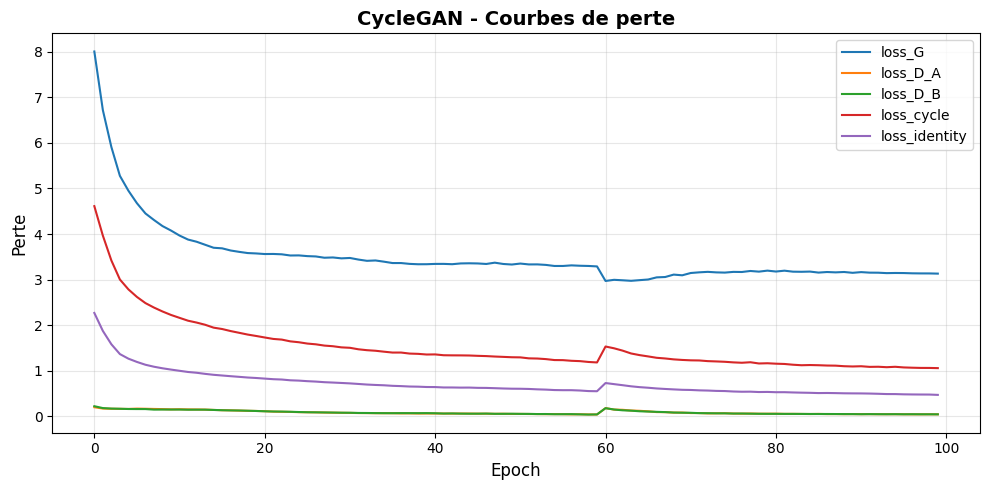

In [12]:
# Afficher les courbes de perte (sauvegardees dans Drive)
plot_training_losses(
    history,
    title='CycleGAN - Courbes de perte',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/figures/cyclegan_losses.png"
)

## 5. Visualisation des resultats

Preparation des donnees de validation...


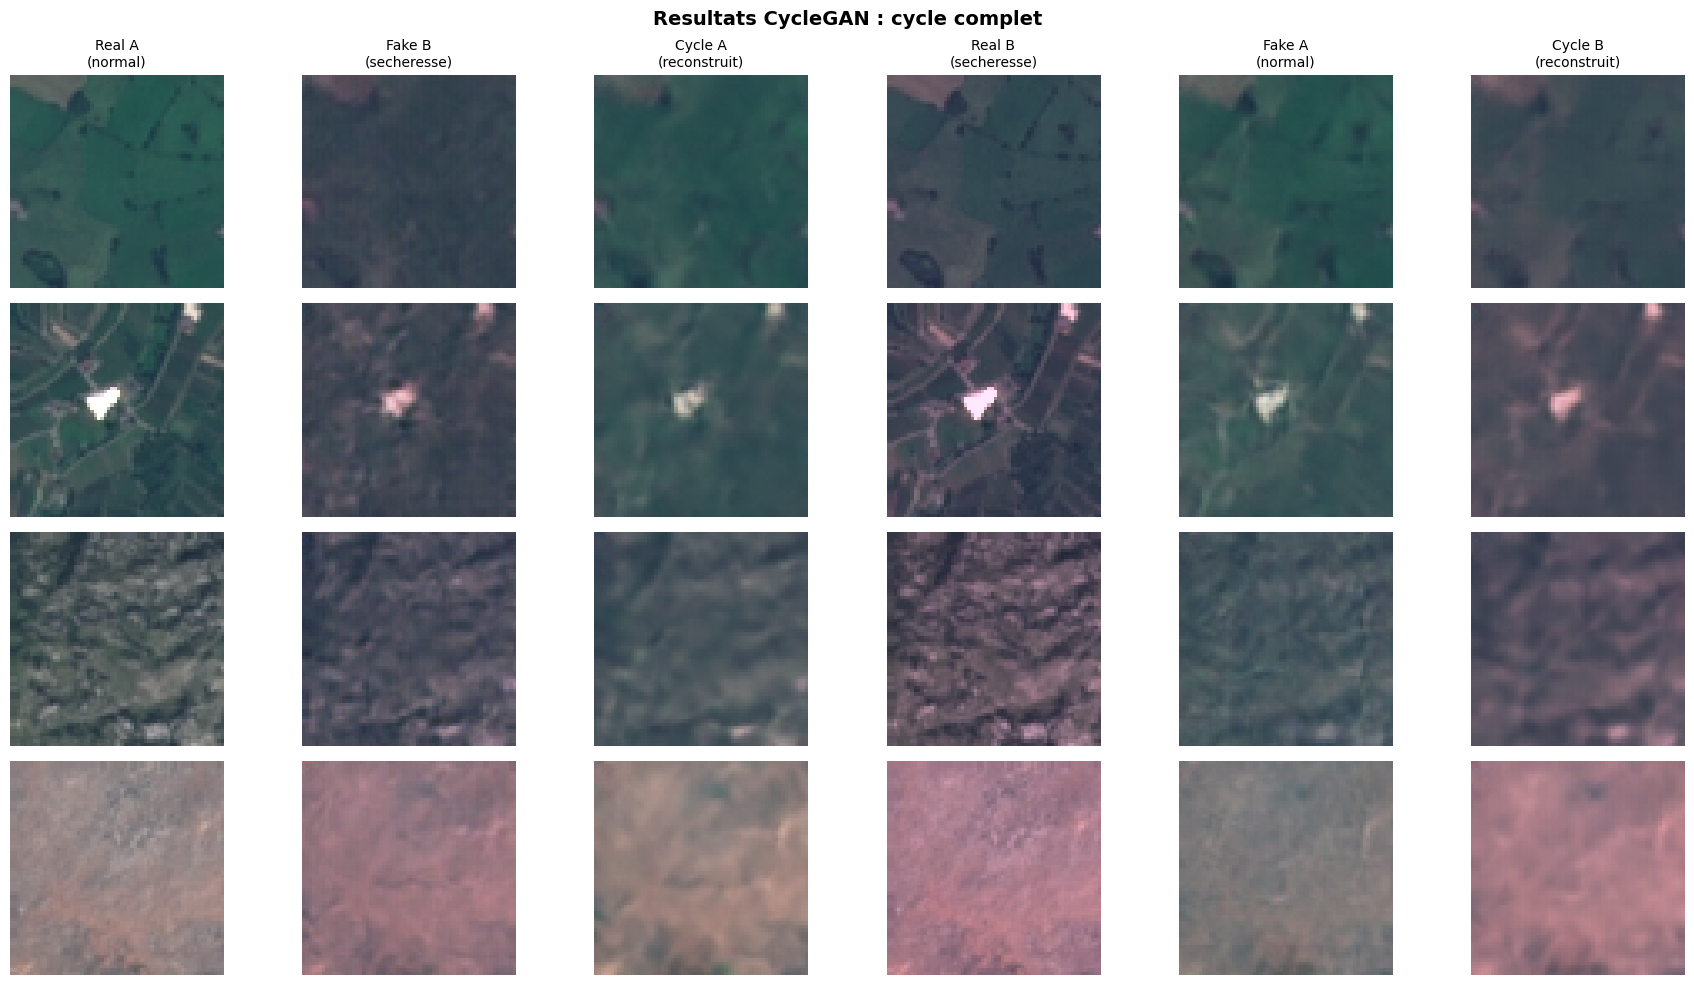

In [13]:
# Preparer quelques images de validation
print("Preparation des donnees de validation...")
val_a, val_b = prepare_paired_batch(val_set, eval_transform, n_max=8)

# Generer les transformations
with torch.no_grad():
    val_a_dev = val_a.to(DEVICE)
    val_b_dev = val_b.to(DEVICE)

    fake_b = trainer.G_A2B(val_a_dev)    # Normal -> Secheresse
    fake_a = trainer.G_B2A(val_b_dev)    # Secheresse -> Normal
    cycle_a = trainer.G_B2A(fake_b)      # Normal -> Secheresse -> Normal
    cycle_b = trainer.G_A2B(fake_a)      # Secheresse -> Normal -> Secheresse

# Afficher les resultats complets (sauvegarde dans Drive)
show_cyclegan_results(
    val_a_dev.cpu(), fake_b.cpu(), cycle_a.cpu(),
    val_b_dev.cpu(), fake_a.cpu(), cycle_b.cpu(),
    n_samples=4,
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/cyclegan_cycle_results.png"
)

Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/cyclegan_normal_vs_drought.png


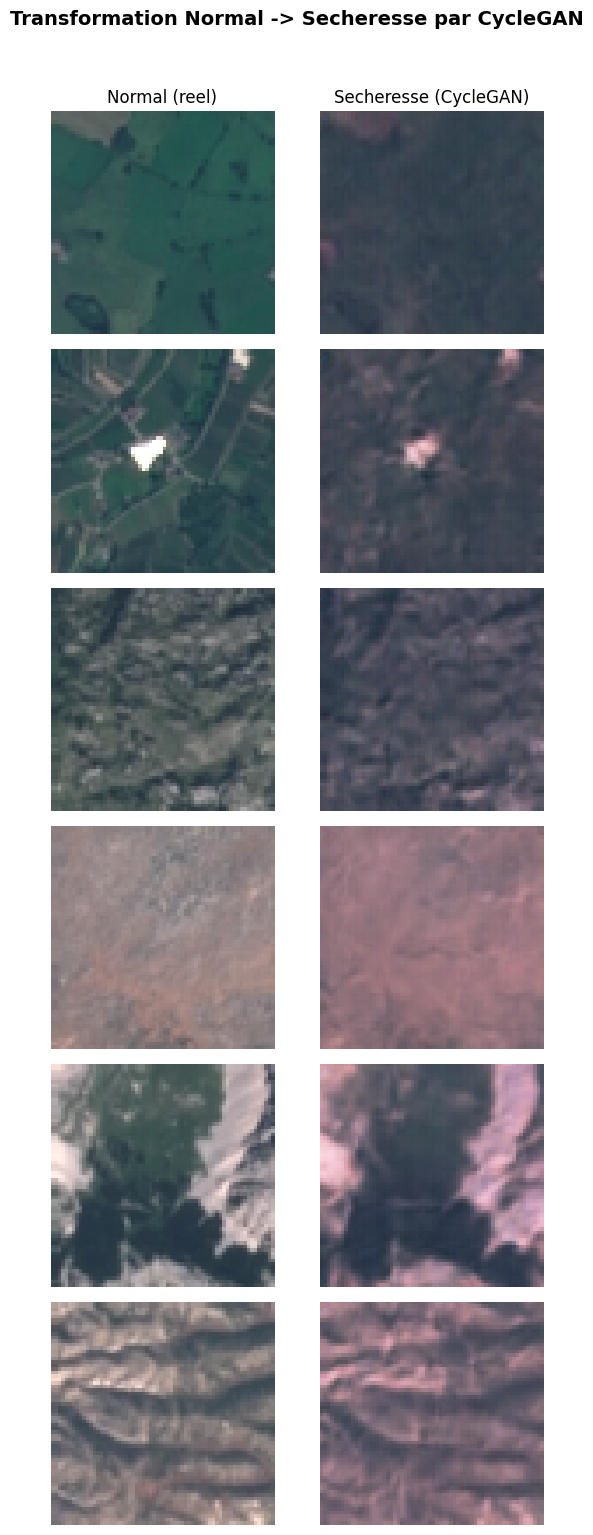

In [14]:
# Comparaison directe Normal vs CycleGAN secheresse
show_comparison(
    val_a.cpu(), fake_b.cpu(),
    n_samples=6,
    labels=('Normal (reel)', 'Secheresse (CycleGAN)'),
    title='Transformation Normal -> Secheresse par CycleGAN',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/cyclegan_normal_vs_drought.png"
)

## 6. Resume

**Observations :**
- Le CycleGAN apprend a transformer les images normales en images seches
- La coherence cyclique preserve la structure spatiale (routes, limites de parcelles)
- La perte d'identite aide a preserver les teintes de couleur

**Sauvegardes dans Drive :**
- `cyclegan/checkpoints/` : checkpoints toutes les 10 epochs + final.pth
- `cyclegan/generated_images/` : images A->B et B->A a chaque sauvegarde
- `cyclegan/losses/loss_history.json` : historique complet des pertes

**Prochaine etape :** Entrainer le modele de diffusion (DDPM) sur les images
de secheresse pour generer de nouveaux echantillons synthetiques.